In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
sys.path.append("..")
from mango.environments import frozen_lake
import utils
import torch
from typing import Any
torch.set_default_device('cpu')

Observation:
 (torch.Size([3, 4, 4]), torch.float32, device(type='cpu'))


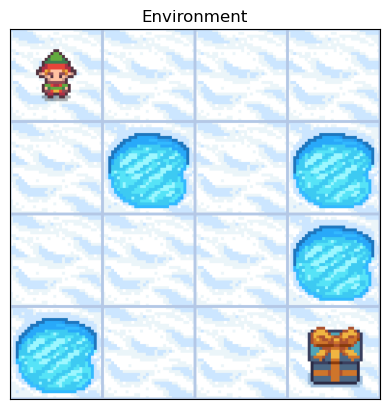

In [2]:
params: dict[str, Any] = dict(map_name="4x4", p=None, shape=(4, 4), seed=42)
env = frozen_lake.wrappers.TensorObservation(
    frozen_lake.wrappers.ReInitOnReset(frozen_lake.CustomFrozenLakeEnv(**params), **params),
    one_hot=True,
)
obs, info = env.reset()
print(f"Observation:\n {obs.shape, obs.dtype, obs.device}")
utils.render(env)

In [3]:
class LazyConvEncoder(torch.nn.Sequential):
    def __init__(self, hidden_channels, out_features):
        layers = []
        for i, channels in enumerate(hidden_channels):
            if i > 0:
                layers.append(torch.nn.LazyBatchNorm2d())
            layers.append(torch.nn.LazyConv2d(channels, 3, padding=1, ))
            layers.append(torch.nn.GELU())
        layers.append(torch.nn.Flatten())
        layers.append(torch.nn.LazyLinear(out_features))
        super().__init__(*layers)

In [4]:
from mango.mango import MangoEnv, Agent
from mango.policies.experiencereplay import ExperienceReplay
from mango.policies.dqnet import DQNetTrainer, DQNetPolicy

net = LazyConvEncoder(hidden_channels=[8, 8, 8], out_features=int(env.action_space.n)).eval()
policy = DQNetPolicy(net, env.action_space)
trainer = DQNetTrainer(net, lr=1e-3, gamma=0.95)
replay = ExperienceReplay(64, out_device="cuda:0")
agent = Agent(MangoEnv(env), policy)

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
import snakeviz
%load_ext snakeviz

In [6]:
%%snakeviz -t
loss_log = []
reward_log = []
eval_reward_log = []

eval_interval = 10
train_steps = 10
for episode in tqdm(range(100)):
    trans = agent.run_episode(randomness=0.1)
    replay.extend(trans.steps)
    reward_log.append(trans.reward)

    if replay.can_sample():
        for _ in range(train_steps):
            info = trainer.train(replay.sample())
            replay.update_priorities_last_sampled(info.td)
            loss_log.append(info.loss)

    if episode % eval_interval == 0:
        trans = agent.run_episode(randomness=0.0)
        eval_reward_log.extend([trans.reward]*eval_interval)       

  0%|          | 0/100 [00:00<?, ?it/s]

Parameter containing:
tensor([[[[ 0.0201, -0.0310, -0.0688],
          [ 0.1367,  0.1438, -0.1813],
          [ 0.1868, -0.0254, -0.0251]],

         [[ 0.0485, -0.1294,  0.0569],
          [-0.0906, -0.0252,  0.1876],
          [ 0.0358,  0.0646,  0.0998]],

         [[-0.1042, -0.0135,  0.0516],
          [-0.0704,  0.0798,  0.0480],
          [-0.0867, -0.1027,  0.1430]]],


        [[[-0.0562,  0.1741, -0.1853],
          [-0.1525,  0.0532, -0.0713],
          [ 0.1924, -0.0702, -0.1427]],

         [[ 0.0054, -0.0888, -0.1771],
          [-0.1915,  0.0087,  0.1116],
          [-0.1267,  0.0255,  0.1754]],

         [[-0.0849,  0.0418, -0.0148],
          [-0.1640, -0.1332, -0.1819],
          [-0.0422, -0.0969, -0.0147]]],


        [[[-0.1705, -0.0709, -0.0107],
          [-0.0019,  0.0593,  0.1824],
          [ 0.1465, -0.0870, -0.1606]],

         [[-0.0528, -0.1137,  0.0570],
          [-0.0411, -0.0035, -0.1275],
          [ 0.1769,  0.1259, -0.0352]],

         [[ 0.1524,  0

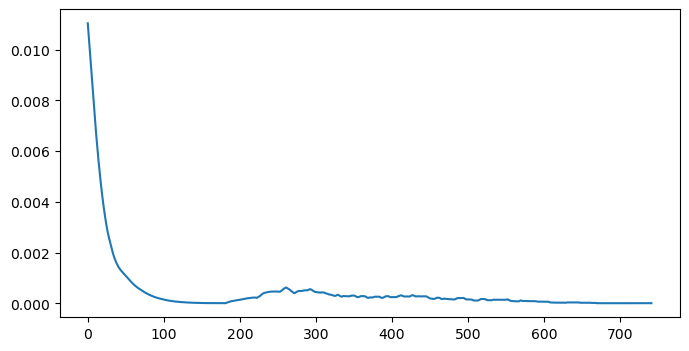

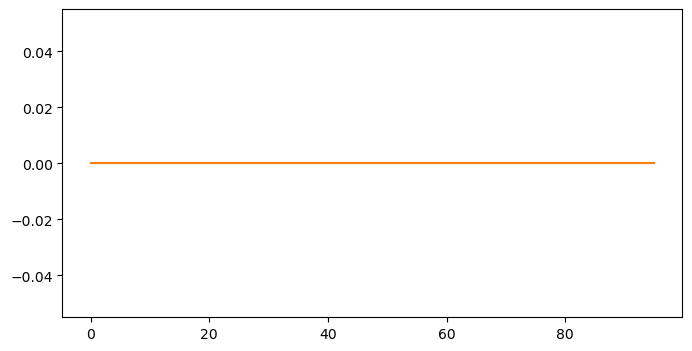

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(utils.smooth(loss_log))
plt.figure(figsize=(8,4))
plt.plot(utils.smooth(reward_log))
plt.plot(utils.smooth(eval_reward_log))

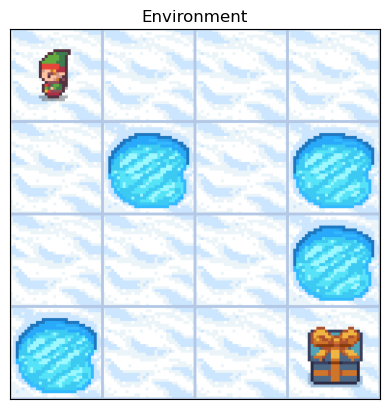

In [ ]:
trans = agent.run_episode(randomness=0.0)
utils.render(env, trajectory=trans.trajectory)